In [ ]:
import glob
import os
import requests
import time
import warnings

warnings.simplefilter('ignore', FutureWarning)

from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# sns.set_style(style='whitegrid')
device_num = 0
torch.cuda.set_device(device_num)

In [ ]:
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

# Полносвязные нейросети

Цель этой части занятия - знакомство с полносвязными нейросетями на примере задачи классификации ирисов. 

**План:**
- Построение простейшей полносвязной нейросети;
- Реализация training loop -- её обучения;
- Замеры качества нейросети как классификатора.


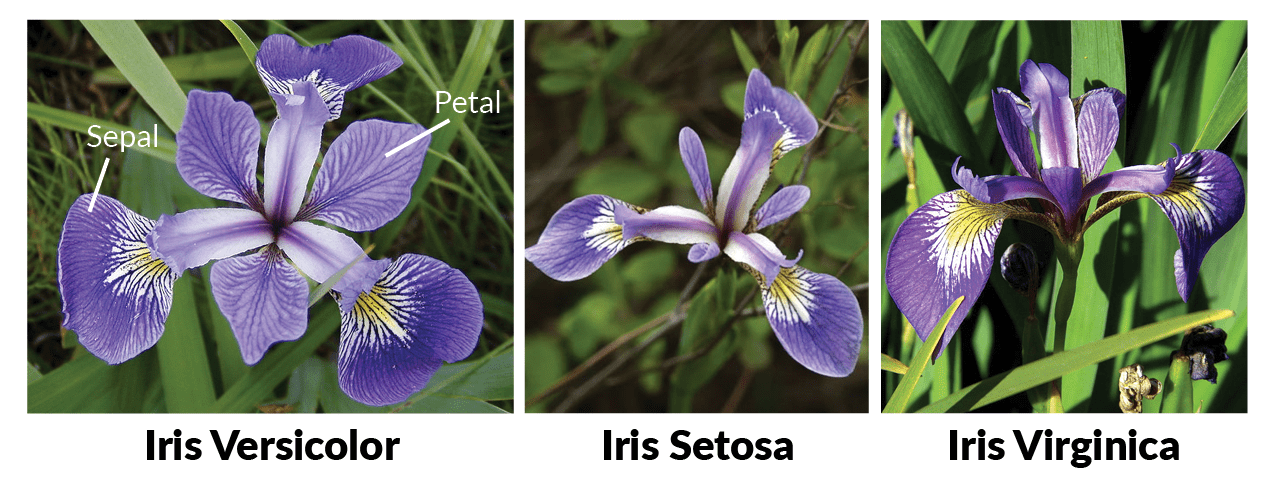

In [ ]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=179
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

Посмотрим на данные, используя код из занятия по `sklearn`.

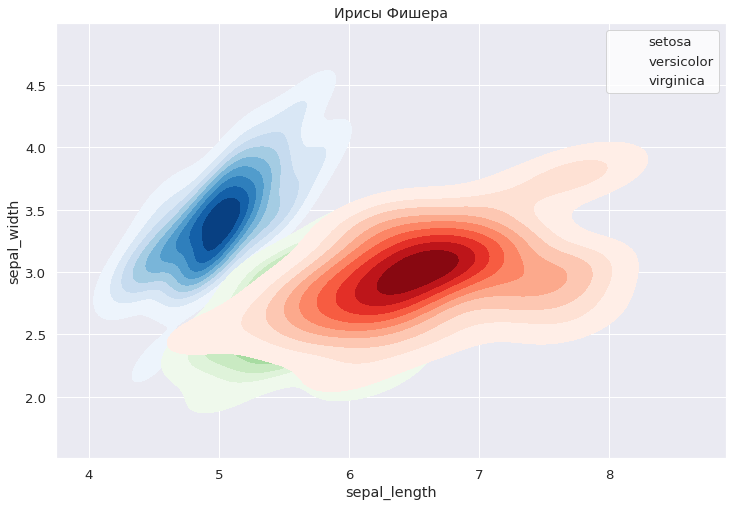

In [ ]:
sns_iris = sns.load_dataset('iris')
setosa = sns_iris[y == 0]
versicolor = sns_iris[y == 1]
virginica = sns_iris[y == 2]

plt.figure(figsize=(12, 8))
with sns.axes_style("darkgrid"):
    ax = sns.kdeplot(
        setosa.sepal_length, 
        setosa.sepal_width, 
        label="setosa", 
        cmap='Blues',
        fill=True
    )
    ax = sns.kdeplot(
        versicolor.sepal_length, 
        versicolor.sepal_width, 
        label="versicolor", 
        cmap='Greens',
        fill=True
    )
    ax = sns.kdeplot(
        virginica.sepal_length, virginica.sepal_width, 
        label="virginica", 
        cmap='Reds',
        fill=True
    )
    ax.set_title("Ирисы Фишера");
    ax.legend().get_frame().set_facecolor("white");

Реализуем простейшую полносвязную архитектуру -- **перцептрон с одним скрытым слоем**. В качестве функций активации между внутренними слоями будем использовать ReLU -- эта функция практически не ухудшает эффективность алгоритма распространения ошибки, но при этом привносит достаточную нелинейность, чтобы быть полезной.

---

Любая нейросетевая архитектура на PyTorch должна быть наследником класса nn.Module, в котором реализованы заглушки методов `forward` -- пропускания данных через нейросеть -- и `backward` -- вычисления градиентов. 

Само составление архитектуры нейросети можно воспринимать как конструктор: вы собираете её из набора блоков, которые "сшиваются" вместе при построении вычислительного графа, по которому PyTorch понимает, как вычислять градиенты методом автоматического дифференцирования. 

Интересно, что в PyTorch этот граф динамический: он сбрасывается после каждого вычисления градиентов, потому структуру сети можно изменять в процессе обучения. В частности, такой подход позволил NVIdia впервые сгенерировать реалистичные человеческие лица в высоком разрешении.

In [ ]:
class IrisPerceptron(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.n_classes = 3
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.n_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.net(x)

Кроме модели нам понадобится функция ошибок, которую традиционно называют `criterion`, и метод оптимизации, который здесь нужно создавать и использовать явно, в отличие от алгоритмов, с которыми мы работали ранее.

In [ ]:
model = IrisPerceptron(
    input_dim=X_train.shape[1], 
    hidden_dim=32
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Посмотрим на нашу нейросеть

In [ ]:
model

IrisPerceptron(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

**Напишем простейший training loop:**

- Пропустили данные через нейросеть;
- Вычислили функцию ошибок;
- Посчитали градиенты по всем обучаемым параметрам;
- Сделали шаг алгоритма backpropagation.

Простейший потому, что ирисы Фишера это маленький датасет, он целиком помещается на GPU. Т.е. нам не нужно нарезать данные на батчи, в связи с чем количество кода сильно уменьшается.

In [ ]:
EPOCHS  = 100

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.float)
        accuracy_list[epoch] = correct.mean().item()

model.eval()

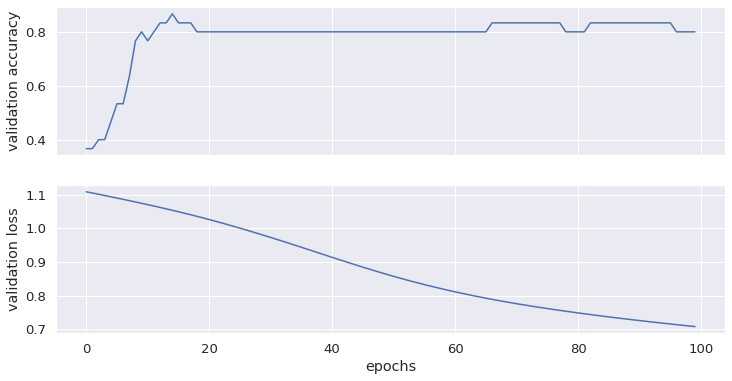

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

In [ ]:
with torch.no_grad():
    y_pred = np.argmax(model(X_test).detach().cpu().numpy(), axis=1)

print(
    classification_report(
        y_test.detach().cpu().numpy(), 
        y_pred
    )
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.75      0.60      0.67        10
           2       0.67      0.80      0.73        10

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



# Сверточные сети и Transfer learning

Цель этой части занятия - знакомство со сверточными сетями и transfer learning на примере классификации картинок. План:

* Convolution, Pooling - базовые слои, их гиперпараметры и интуиция использования;

* Построение сверточной нейросети для классификации картинок;

* Использование Transfer Learning для этой же задачи.

### Convolution (свёртка)

Основные гиперпараметры:

* `in_channels` (int) - количество каналов во входном изображении

* `out_channels` (int) - количество каналов после применения свертки (кол-во ядер (фильтров), которые будут применены)

* `kernel_size` (int, tuple) - размер сверточного ядра

* `stride` (int, tuple) - шаг, с которым будет применена свертка. Значение по умолчанию 1

* `padding` (int, tuple) - добавление по краям изображения дополнительных пикселей. Значение по умолчанию 0

* `padding_mode` (string, optional) - принцип заполнения краёв. Значение по умолчанию 'zeros'

`nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, padding_mode='zeros')`
 ![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

 Берем `out_channels` фильтров размера  `in_channels` x `kernel_size` x `kernel_size`. Каждым фильтром 'проходим' по изображению с шагом `stride`, поэлементно умножаем его на область изображения размером `in_channels` x `kernel_size` x `kernel_size`, складываем получившиеся поэлемнетные произведения и записываем это число в результирующий тензор. В итоге получаем `out_channels` выходных тензоров.

 **Интуиция**:
 
В FC слоях мы соединяли нейрон с каждым нейроном на предыдущем слое. Теперь нейрон соединен только с ограниченной областью выхода предыдущего слоя. Иногда эту область называют *рецептивном полем (receiptive field)* нейрона. 

Такое изменение необходимо из-за большой размерности входных данных. Например, если размер входного изображения $3 \cdot 224 \cdot 224$, то каждый нейроне в FC-слое будет содержать $3\cdot 224\cdot 224=150\:528$ параметров, что очень много. При этом мы захотим добавить нелинейности в нашу архитектуру, так что у нас будет несколько таких слоёв.



*Задача на понимание:*

К изображению (3, 224, 224) применяют свертку `nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2, bias=True)`. 

* Какой будет размер выходного изображения? 

(224 - 5 + 4) // 2 + 1 = 111 + 1 = 112

= (64, 112, 112)

* Cколько у данного слоя обучаемых параметров?

5 * 5 * 3 * 64 + 64

*Проверяем себя:*

In [ ]:
5*5*3*64

4800

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, 
                                    kernel_size=5, stride=2, padding=2))

from torchsummary import summary

summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           4,864
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 6.12
Params size (MB): 0.02
Estimated Total Size (MB): 6.72
----------------------------------------------------------------


Посмотрим на то, как применение свёртки с определёнными фильтрами влияет на изображение и как будет меняться картинка в зависимости от фильтра:

In [ ]:
! wget https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg

--2021-05-05 14:18:32--  https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg
Resolving www.kotzendes-einhorn.de (www.kotzendes-einhorn.de)... 94.130.145.107
Connecting to www.kotzendes-einhorn.de (www.kotzendes-einhorn.de)|94.130.145.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64098 (63K) [image/jpeg]
Saving to: ‘lenna.jpg’

lenna.jpg           100%[===================>]  62.60K  --.-KB/s    in 0.09s   

2021-05-05 14:18:33 (702 KB/s) - ‘lenna.jpg’ saved [64098/64098]



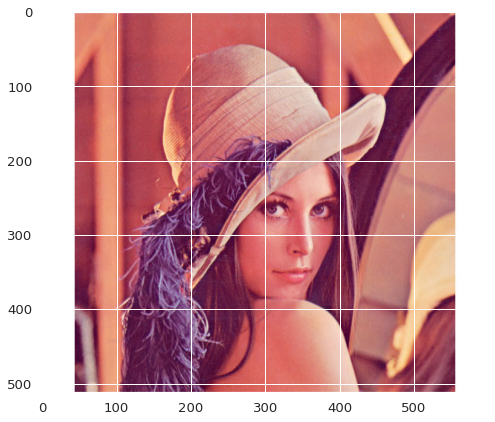

In [ ]:
img = plt.imread('./lenna.jpg')

plt.figure(figsize=(12,7))
plt.imshow(img);

In [ ]:
type(img)

numpy.ndarray

Функция для инициализации весов слоя:

In [ ]:
def init_conv(kernel):
    conv = nn.Conv2d(
        in_channels=3, out_channels=1, 
        kernel_size=3, bias=False
    )
    conv.weight = torch.nn.Parameter(
        torch.FloatTensor(kernel), 
        requires_grad=False
    )
    return conv

Функция для свертки изображения с одним фильтром:

In [ ]:
def convolution(kernel, img, transforms):
    conv = init_conv(kernel)
    img_tensor = transform(img)
    # добавим батч-размерность
    res = conv(img_tensor.unsqueeze(0))
    res = res.detach().squeeze().numpy()
    # пиксели имеют значения от 0 до 255
    res = (np.clip(res, 0, 1)*255).astype(int)
    return res

Numpy-картинку нужно привести к torch-тензору:

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(), 
    transforms.ToTensor()
])

Зададим фильтры:

In [ ]:
kernel_1 = torch.FloatTensor([[[
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]]])

kernel_2 = torch.FloatTensor([[[
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
]]])

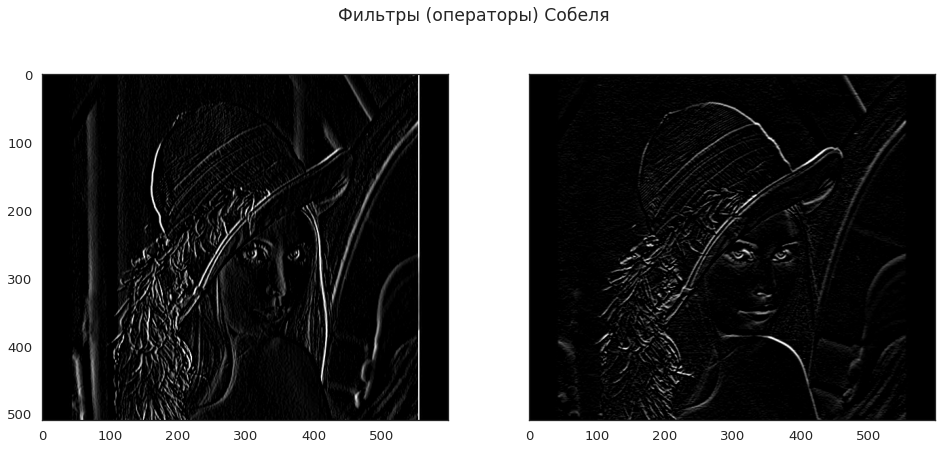

In [ ]:
sns.set_style(style='white')

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 7), 
    sharey=True, sharex=True
)

res_images = []
for fig_x, kernel in zip(ax.flatten(), [kernel_1, kernel_2]):
    res = convolution(kernel, img, transform)
    fig_x.imshow(res, cmap='gray')
    res_images.append(res)
plt.suptitle('Фильтры (операторы) Собеля')
plt.show()

Чем более пиксель белый, тем больше его значение. Если присмотреться, то можно заметить, как на первом результате фильтр (ядро) делает более значимыми (белыми) пиксели, соответствующие вертикальным линиям: нос, полоска справа, волосы, а на втором $-$ горизонтальным: брови, губы.

Это как раз согласуется со значениями в фильтрах (ядрах): первый вычисляет перепады значений в пикселях по вертикали, второй $-$ по горизонтали. 

С помощью этих фильтров легко прийти к методу выделения границ на изображении: поскольку каждая граница состоит из $x$ и $y$ компоненты, то используем теорему Пифагора и вычислим суммарное значение:

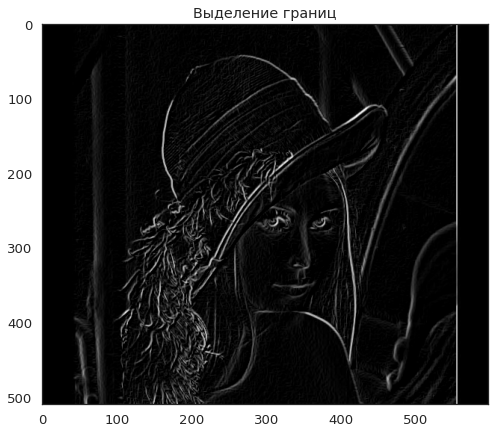

In [ ]:
img_sobel = np.sqrt(res_images[0]**2 + res_images[1]**2)

plt.figure(figsize=(12,7))
plt.title('Выделение границ')
plt.imshow(img_sobel, cmap='gray')
plt.show()

Этот метод называет также [оператором Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F). Так, мы посмотрели как работает свертка на примере оператора Собеля. 

### Pooling

Основные гиперпараметры:

* `kernel_size` (int, tuple) - размер ядра

* `stride` (int, tuple) - шаг, с которым будет применен pooling. Значение по умолчанию `kernel_size`

* `padding` (int, tuple) - добавление по краям изображения нулей

Основные виды pooling-ов: `MaxPooling` (берется максимум элементов), `AveragePooling` (берется среднее элементов).

![](https://sun9-10.userapi.com/c854016/v854016674/22a457/mpE8Idra-5Y.jpg)

**Интуиция:**

1. cнижаем размерность изображения и, как следствие, вычислительную сложность

2. увеличиваем рецептивное поле на входном изображении для нейронов следующих сверточных слоев

При этом многие исследователи ставят под сомнение эффективность pooling слоёв. Например, в статье [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806) предлагается заменить его на свертки с большим stride-ом. Также считается, что отсутствие pooling слоёв хорошо сказывается на обучении генеративных моделей, но споры ещё ведутся: [FCC-GAN: A Fully Connected and Convolutional Net
Architecture for GANs](https://arxiv.org/pdf/1905.02417.pdf)


**Вопрос:** сколько параметров у pooling слоя?

Применим наши знания для решения конкретной задачи:

##  CIFAR10

Датасет состоит из 60k картинок 32х32х3. 

50k - обучающая выборка, 10k - тестовая. 

10 классов: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

 ![](https://sun9-72.userapi.com/c857216/v857216523/12dbca/vdSCet5LS_0.jpg)

Загружаем датасет:

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)
# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [40000, 10000]
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
!nvidia-smi

Wed May  5 18:06:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |   7092MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Инициализируем генераторы батчей:

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

Пайплайн обучения:

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

Функция для обучения нейросети:

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

### Baseline

Начнем с простой линейной модели, в духе той, которую рассмотрели на прошлой части занятия

In [ ]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''

        super(MySimpleModel, self).__init__()
        # входное количество признаков = высота * ширина * кол-во каналов картинки
        # сейчас 64 нейрона в первом слое
        self.linear1 = nn.Linear(3 * 32 * 32, 64)
        # 10 нейронов во втором слое
        self.linear2 = nn.Linear(64, 10)  # логиты (logits) для 10 классов
        
    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        return x

Применим ее к нашим данным $-$ картинками из CIFAR10:

Epoch 22 of 50 took 5.236s
  training loss (in-iteration): 	1.459198
  validation loss (in-iteration): 	1.537281
  training accuracy: 			48.88 %
  validation accuracy: 			45.76 %


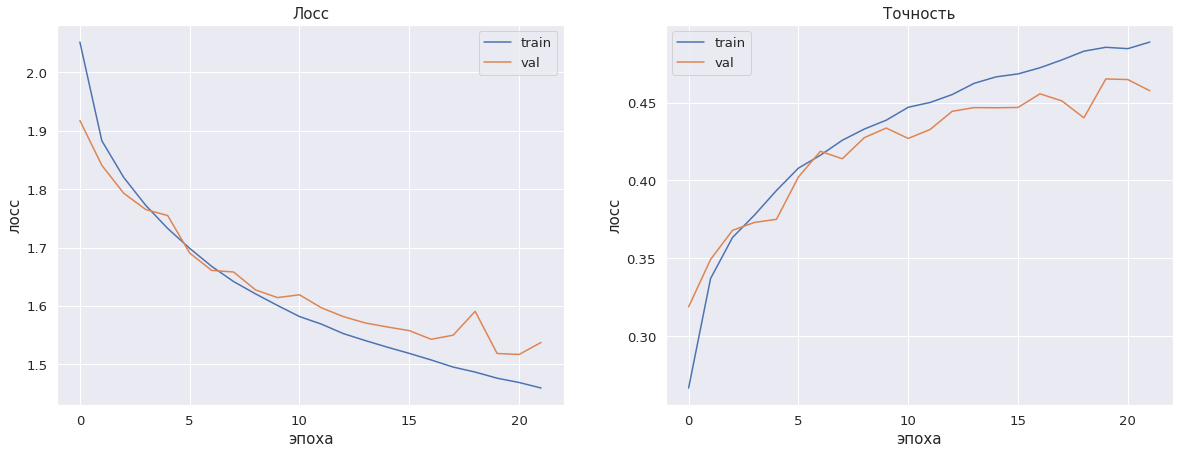

KeyboardInterrupt: ignored

In [ ]:
model = MySimpleModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=50
)

### Свёрточная нейросеть

*Свёрточная нейросеть (Convolutional Neural Network, CNN)* - это многослойная нейросеть, имеющая в своей архитектуре свёрточные слои (Conv Layers) и pooling-слои (Pool Layers).

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:

$INPUT \to [[CONV -> RELU]^N \to POOL?]^M \to [FC -> RELU]^K \to FC$

"?" обозначает опциональные слои.

![](https://sun9-64.userapi.com/c856028/v856028087/1eae7b/GrKeqELsvWM.jpg)

Подробнее:

1). Входной слой (batch картинок HxWxC)

2).  $M$  блоков ($M  \ge  0$) из свёрток и pooling-ов. Все эти  $M$  блоков вместе называют *feature extractor* свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются.

При этом лучше использовать несколько сверток с маленьким рецептивным полем, чем одну свертку с большим рецептивным полем.

3).  $K$  штук FullyConnected-слоёв (с активациями). Эту часть из  $K$  FC-слоёв называют *classificator*, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).

*Замечание*:  Pooling layer можно пропустить и не включать в архитектуру, но при этом он снижает размерность, а следовательно и вычислительную сложность, а также помогает бороться с переобучением

**Пример, почему 3 свертки 3х3 экономнее по памяти, чем одна свертка 7x7:**

Предположим, что входное изображение имеет $C$ каналов, и что количество фильтров в сверточных слоях тоже равно $C$.

1). **[CONV((3, 3)) -> RELU]^3**

Количество параметров: $3(C(C*3*3)) = 27C^2$
    
Рецептивное поле первой свертки на входном изображении: $3\times3$
    
Рецептивное поле второй свертки на выходе первой свертки: $3\times3$, и, следовательно, $5\times5$ на входном изображении.
    
Аналогично рецептивное поле третьей свертки (а значит и всего блока) на входном изображении: $7\times7$
    

2). **[CONV((7, 7)) -> RELU]^1**

Количество параметров: $C(C*7*7) = 49C^2$
    
Рецептивное поле на входном изображении: $7\times7$
    
**Вывод:** Первый вариант формирует более сложные признаки из-за нелинейностей, при этом имеет меньше параметров и такое же рецептивное поле на входном изображении.



Также нужно не забывать о пользе `Dropout` и `BatchNorm`:

* `Dropout` позволяет бороться с переобучением, можно интерпретировать как обучение ансамбля моделей
* `BatchNorm` нормирует данные, делает веса на более поздних слоях менее чувствительными к изменениям весов на начальных слоях. Таким образом `BatchNorm` позволяет сделать нейросеть более стабильной при изменении распределения входных данных.

#### Задание:
 
 Посмотрите на следующую нейросеть и укажите на некорректные шаги в реализации.


In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(3, 2048, kernel_size=5, stride=2, padding=3))
model.add_module('mp1', nn.MaxPool2d(7))
model.add_module('conv2', nn.Conv2d(2048, 64, kernel_size=3))
model.add_module('mp2', nn.MaxPool2d(2))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('dp1', nn.Dropout(0.5))
model.add_module('relu1', nn.ReLU())

model.add_module('conv3', nn.Conv2d(64, 128, kernel_size=(20, 20)))
model.add_module('mp3', nn.MaxPool2d(2))
model.add_module('conv4', nn.Conv2d(128, 256, kernel_size=(20, 20)))

model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(1024, 512))
model.add_module('fc2', nn.Linear(512, 10))
model.add_module('dp2', nn.Dropout(0.05))

> Подсказка:
    
* нет активаций после сверток (свертка по своей сути - линейное преобразование и активации нужны, чтобы добавить нелинейность)

* слишком много выходных каналов в `conv1`. Увеличили число параметров слишком сильно: мы потратим гораздо больше времени на обучение при этом получив много повторяющихся сверток

* теряем слишком много информации в `mp1`, размер ядра нужно уменьшить

* теряем слишком много информации в `dp1`

* слишком большой `kernel_size` в `conv3` и `conv4`, этот код не сможет скомпилироваться, потому что размер изображения будет меньше, чем `kernel_size`

* два линейных слоя подряд `fc1` и `fc2` без активации между ними можно заменить одним синейным слоем

* `droupout` в конце просто зануляет часть выходов к лоссу, а не выключает связи между нейронами. Тем самым мы теряем уже выученную информацию, а не боремся с переобучением.


#### Задание:

На основе предыдущего примера:
1. Исправьте все ошибки и реализуйте свою сверточную сеть;
2. Обучите её и посмотрите на качество.

Не забывайте о пользе `Dropout` и `BatchNorm`.

In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        model = nn.Sequential()
        # Блок 1: Свёртка с большим ядром, чтобы уловить общие закономерности
        model.add_module(
            'conv1', 
            nn.Conv2d(
                3, 16, 
                kernel_size=5,  
                padding=2
            )
        )
        # Важно! Батч-нормализация всегда идёт до функции активации!
        model.add_module('bn1', nn.BatchNorm2d(16))
        model.add_module('mp1', nn.MaxPool2d(2))
        model.add_module('dp1', nn.Dropout(0.2))

        # Блок 2: Свёртка с ядром поменьше, выделяет более тонкие признаки.
        model.add_module('conv2', nn.Conv2d(16, 32, kernel_size=3, padding=1))
        model.add_module('bn2', nn.BatchNorm2d(32))
        model.add_module('mp2', nn.MaxPool2d(2))
        # Важно! Дропаут идёт после функции активации!
        model.add_module('dp2', nn.Dropout(0.2))

        # Блок 3: Линейный слой поверх карт активации
        model.add_module('flatten', nn.Flatten())
        model.add_module('fc1', nn.Linear(2048, 512))
        model.add_module('bn3', nn.BatchNorm1d(512))
        model.add_module('relu1', nn.ReLU())
        model.add_module('dp3', nn.Dropout(0.2))

        # Блок 4: Классификационный слой
        model.add_module('fc2', nn.Linear(512, 10))
        self.model = model

    def forward(self, x):
        return self.model(x)

Epoch 22 of 50 took 6.682s
  training loss (in-iteration): 	0.680106
  validation loss (in-iteration): 	1.136912
  training accuracy: 			76.55 %
  validation accuracy: 			63.05 %


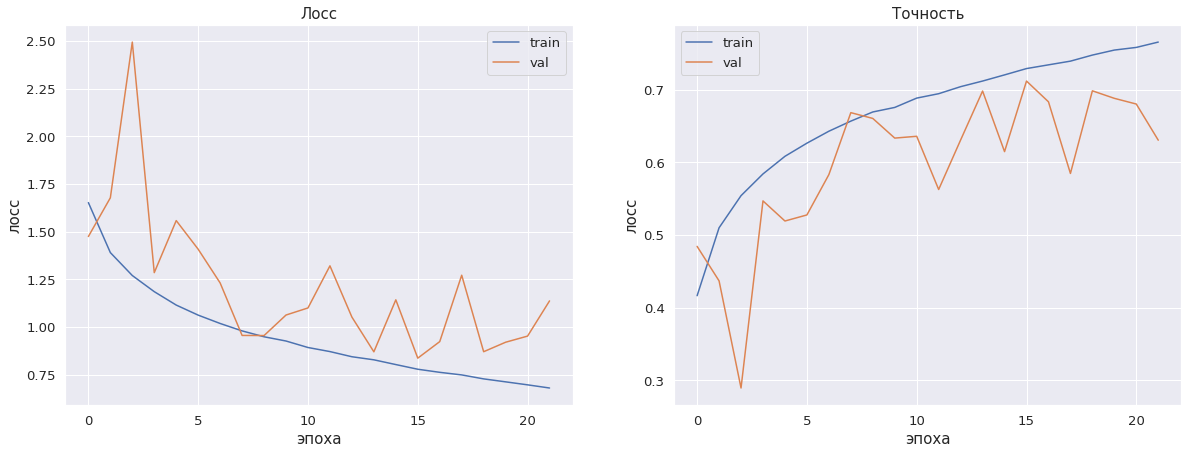

KeyboardInterrupt: ignored

In [ ]:
model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

> Сравните полученное качество с тем, что мы получили ранее для MLP.

### Data augmentations

![](https://sun9-5.userapi.com/c857216/v857216818/1815e6/OxQ8e3-o0oU.jpg)

Data augmentations - это метод, направленный на увеличение размеров обучающей выборки. Дополнение обучающей выборки разнообразными, "хорошими" и "плохими" примерами, позволяет получить модель более устойчивую на тестовых данных, так как для неё в тестовых данных будет меньше "неожиданностей".

С помощью `torchvision.transforms` мы применим несколько случайных преобразований к картинкам и тем самым расширим нашу выборку. Про все реализованные в библиотеке преобразования можно почитать [здесь](https://pytorch.org/docs/stable/torchvision/transforms.html).

В данном случае в качестве аугментации мы используем:

* `ColorJitter` - изменение яркости, контраста, насыщенности цветов
* `RandomAffine` - афинное преобразование

In [ ]:
from torchvision import transforms


# набор аугментаций при обучении
transform_train = transforms.Compose([
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

# набор аугментаций при валидации
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

Загружаем данные, но уже *с аугментациями*:

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform_train
)
# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


Инициализируем даталоадеры:

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

Обучим нейросеть на новых данных:

Epoch 50 of 50 took 24.323s
  training loss (in-iteration): 	1.915789
  validation loss (in-iteration): 	1.921518
  training accuracy: 			55.91 %
  validation accuracy: 			55.83 %


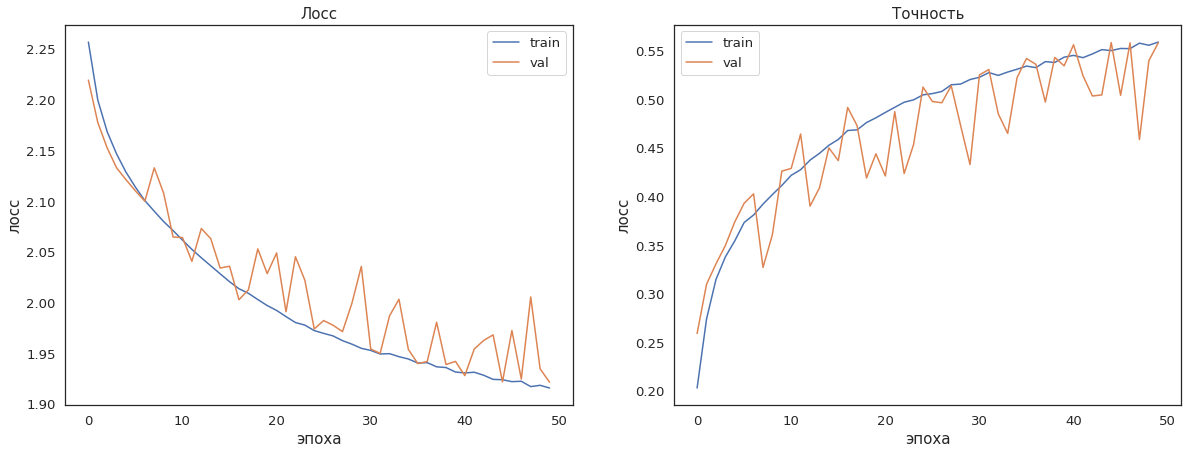

In [ ]:
model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

Каждую эпоху для каждого изображения выбирается случайная трансформация. Таким образом каждую эпоху нейросеть обучается на одном и том же количестве изображений, но они каждый раз разные.

> Сравните, как аугментация влияет на качество на обучении и на валидации.

## Transfer Learning

[Transfer Learning](https://arxiv.org/abs/1808.01974v) - это процесс дообучения на *новых данных* какой-либо нейросети, предобученной до этого на других данных. Обычно предобучение производят на хорошем, большом (миллионы картинок) датасете (например, ImageNet ~ 14 млн картинок).

На данный момент есть множество предобученных моделей: `AlexNet`, `DenseNet`, `ResNet`, `VGG`, `Inception` и другие, а также их различные модификации. Все они отличаются архитектурой и входными данными.

### Описание метода:

Представим, что eсть новый набор данных, и вы хотите научить сеть классифицировать объекты из этой выборки.  

* **1. Fine Tuning** (дообучение CNN)  
   * Берём сеть, обученную на ImageNet;
   * Убираем последние Fully-Connected слои сети, отвечающие за классификацию;
   * Размораживаем все или несколько предыдущих слоев сети (`param.requires_grad = True`), начиная с последнего (**не** с первого);
   * Обучаем получившуюся архитектуру на новых данных (пару FC-слоёв, например).

* **2. Feature Extractor** (CNN как средство для извлечения признаков)
    * Берём сеть, обученную на ImageNet;
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию;
    * Замораживаем (`param.requires_grad = False`) веса всех предыдущих слоёв 
    * Обучаем на выходах полученной сети свой классификатор (пару FC-слоёв, например) на новых данных.

Ниже эти подходы изображены на примере VGG архитектуры:
    
<img src="https://sun9-66.userapi.com/c857632/v857632819/1ea161/rtU9L7NIrag.jpg" alt="tfl" width="600"/>

<style>
div.input {

В зависимости от количества и природы Ваших данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* *У Вас **мало данных** ($\le 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  

    * если данные совсем похожи, можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит обратиться к методу Feature Extractor
    * Fine Tuning лучше не использовать. Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning, то сеть может переобучиться, поскольку данных мало

* *У Вас **мало данных** ($\le 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*  
    * в данном случае мы *не можем* ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует использовать Feature Extractor, но брать как признаки выходы более ранних слоёв. Ведь, как ожидается, они соответствуют более общим паттернам в данных.
* *У Вас **много данных** ($\ge 10k$), и они **похожи** на данные, на которых была обучена сеть до этого*  
    * можно попробовать использовать готовую модель
    * если качество Вас не устраивает, то тогда стоит cделать Fine-Tuning, ведь данных много, и вероятность переобучения меньше. Имеет смысл попробовать разморохить веса последних нескольких слоёв (можно разморозить и всю сеть)
* *У Вас **много данных** ($\ge 10k$), и они **не похожи** на данные, на которых была обучена сеть до этого*
    * Fine-Tuning практически всей сети. Веса предобученной сети оставляют в качестве инициализации для обучения на новых данных
    
display:none;
}
</style>

В зависимости от нового датасета имеет смысл использовать разные стратегии дообучения:
- если датасет *похож* на тот, на котором модель предобучена, то возможно стоит просто заменить слой классификации;
- если датасет *не похож*, то возможно стоит разморозить и сверточные слои тоже. 

**Эмпирическое правило**: *чем больше новый датасет не похож* на тот, на котором обучали модель, *тем больше слоев с конца стоит размораживать*.

Если новый датасет достаточно большой (на каждый класс > 1000 изображений), то можно попробовать разморозить всю нейросеть и обучить со случайных весов, как мы это делали до того, как узнали про Transfer Learning.

Рассмотрим [**ResNet50**](https://arxiv.org/abs/1512.03385), предобученную на одном из самых крупных датасетов картинок ImageNet, который содержит 1000 классов. Подробнее про данный датасет можно почитать [здесь](http://image-net.org/}).

Архитектура **ResNet50** основана на residual connections, которые позволяют избежать затухания градиентов:

![](https://sun9-72.userapi.com/c855620/v855620860/204ab7/DHbavFbU7QU.jpg)

Загрузим предобученную модель.

In [ ]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)  # скачиваем предобученные веса

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Скачаем названия классов для картинок из ImageNet.

In [ ]:
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

--2021-05-05 15:28:30--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14193 (14K) [text/plain]
Saving to: ‘imagenet-simple-labels.json’

imagenet-simple-lab 100%[===================>]  13.86K  --.-KB/s    in 0s      

2021-05-05 15:28:31 (97.8 MB/s) - ‘imagenet-simple-labels.json’ saved [14193/14193]



In [ ]:
import json
with open('imagenet-simple-labels.json', 'r') as labels_file:
    labels = {i: val for i, val in enumerate(json.load(labels_file))}

 Скачаем картинку альбатроса и посмотрим какой ответ дает предобученная сеть.

In [ ]:
!wget https://i.ibb.co/60RmQ6S/albatross.jpg -O albatross.jpg

--2021-05-05 15:29:14--  https://i.ibb.co/60RmQ6S/albatross.jpg
Resolving i.ibb.co (i.ibb.co)... 104.194.8.196, 172.96.140.18
Connecting to i.ibb.co (i.ibb.co)|104.194.8.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘albatross.jpg’

albatross.jpg       100%[===================>]  11.33K  --.-KB/s    in 0.005s  

2021-05-05 15:29:16 (2.03 MB/s) - ‘albatross.jpg’ saved [11607/11607]



Приведем картинку к нужному формату и напишем функцию для предсказания топ-10 классов для картинки.

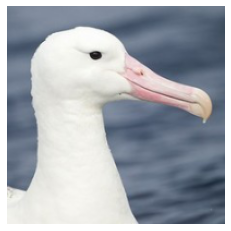

top-10 classes are: 
 [prob : class label]
0.9900 :	albatross
0.0042 :	spoonbill
0.0019 :	hammerhead shark
0.0013 :	great egret
0.0010 :	goose
0.0002 :	pelican
0.0002 :	oystercatcher
0.0001 :	crane (bird)
0.0001 :	black swan


In [ ]:
from skimage.transform import resize

# приводим изображение к размеру 200х200
img = resize(plt.imread('albatross.jpg'), (200, 200))

# покажем получившуюся картинку
plt.imshow(img)
plt.axis('off')
plt.show()


def predict(img):
    '''
    Вывести 10 самых вероятных классов, согласно предсказания модели.

    '''
    model.train(False)

    # ! Обратите внимание на то, как картинка-`np.array` приводится к картинке-тензору
    img = torch.FloatTensor(img.reshape([1, 200, 200, 3]).transpose([0, 3, 1, 2]))
    
    # Софтмакс-преобразование логитов нейросети
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

#### Практика Transfer Learning: Симпсоны

Рассмотрим датасет "Симпсоны". Он скачивается в ячейке ниже, оригинал лежит по [ссылке](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/download).

In [ ]:
# Альтернативно можно раскомментировать эту ячейку, загрузив свой kaggle.json из Kaggle.
# Для того, чтобы скачать kaggle.json, нужно войти в свой аккаунт 
# https://www.kaggle.com/<username>/account
# и нажать на "Create New Api Token" (Ctrl+F)

# !pip install -q kaggle
# from google.colab import files

# files.upload()

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d alexattia/the-simpsons-characters-dataset
# ! unzip the-simpsons-characters-dataset.zip -d simpsons_dataset

In [ ]:
import subprocess

def upload_file_from_gdrive(file_id, outfile):
    upload_cmd = (
        "wget --load-cookies /tmp/cookies.txt"
        " \"https://docs.google.com/uc?export=download&confirm=$("
        " wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies"
        f" --no-check-certificate 'https://docs.google.com/uc?export=download&id={file_id}'"
        f" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\\1\\n/p')&id={file_id}\" "
        f" -O {outfile} && rm -rf /tmp/cookies.txt"
    )
    subprocess.check_call(upload_cmd, shell=True)

upload_file_from_gdrive(
    file_id='1yMJn1db-T7HETlVpKMkvhrcJ-_sT8JMx', 
    outfile='the-simpsons-characters-dataset.zip'
)

In [ ]:
%%capture
!unzip the-simpsons-characters-dataset.zip -d simpsons_dataset

Streaming output truncated to the last 5000 lines.
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_1159.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_0247.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_0253.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_0535.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_1398.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_0086.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_0938.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_0092.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_0079.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_1415.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_1373.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ned_flanders/pic_1429.jpg  
  inflating: simpsons_dataset/simpsons_dataset/ne

In [ ]:
train_dir = 'simpsons_dataset/simpsons_dataset'

Разделим данные на обучение и валидацию:

In [ ]:
class SplitImageFolder():

    def __init__(self, train_dir):

        self.train_dir = train_dir
        self.train_val_files_path = glob.glob(f'{train_dir}/*/*.jpg')
        self.train_val_labels = [path.split('/')[-2] for path in self.train_val_files_path]

    def split(self, test_size=0.3):

        train_files_path, val_files_path = train_test_split(
            self.train_val_files_path, 
            test_size=test_size,
            stratify=self.train_val_labels
        )

        files_path = {'train': train_files_path, 'val': val_files_path}

        return files_path

In [ ]:
files_path = SplitImageFolder(train_dir).split()

Минимальный размер изображения, с которым работает `ResNet50` $-$ $200\times200$. 

В компьютерном зрении часто возникает такая ситуация -- картинки в датасете разного размера и качества. Чаще всего их приводят к одному размеру, например, $256\times256$ или $512\times512$. 

Приведем все входные изображения к этому размеру с помощью `transforms.Resize`. 

In [ ]:
input_size = 200

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    train_dir, 
    transform=train_transform,
    is_valid_file=lambda x: x in files_path['train']
)

val_dataset = torchvision.datasets.ImageFolder(
    train_dir, 
    transform=val_transform,
    is_valid_file=lambda x: x in files_path['val']
)

In [ ]:
print("Количество классов: ", len(train_dataset.classes))

Количество классов:  47


Визуализируем данные:

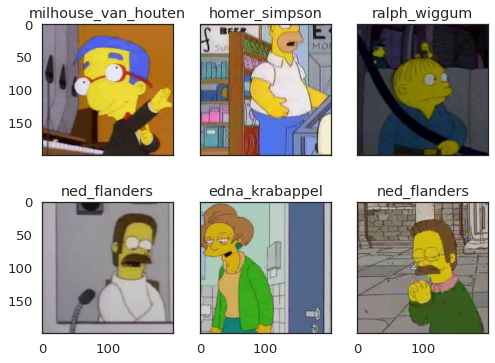

In [ ]:
sns.set_style(style='white')

fig, ax = plt.subplots(
    nrows=2, ncols=3, figsize=(8, 6),
    sharey=True, sharex=True
)

for fig_x in ax.flatten():
    idx = np.random.randint(low=0, high=6000)
    img, label = val_dataset[idx]
    fig_x.set_title(val_dataset.classes[label])
    fig_x.imshow(img.numpy().transpose((1, 2, 0)))

#### Fine Tuning сети ResNet50

In [ ]:
# summary(fine_tuning_model.to(device), (3, 200, 200))

Снова инициализируем даталоадеры, так как они являются генераторами:

In [ ]:
batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Добавляем новые слои классификации под датасет Симпсонов (47 классов):

In [ ]:
fine_tuning_model = nn.Sequential()

# предобученная на датасете ImageNet нейросеть ResNet50
fine_tuning_model.add_module('resnet', resnet50(pretrained=True))

# добавляем 2 FC слоя после выходов предобученной неросети
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 47))

fine_tuning_model = fine_tuning_model.to(device)

Убедимся, что все параметры сети "разморожены", то есть являются обучаемыми:

In [ ]:
for param in fine_tuning_model.parameters():
    assert(param.requires_grad)
    assert(param.is_cuda)

Зафайнтюним эту модель на наших данных:

Epoch 5 of 5 took 266.117s
  training loss (in-iteration): 	0.111141
  validation loss (in-iteration): 	0.149291
  training accuracy: 			97.02 %
  validation accuracy: 			96.56 %


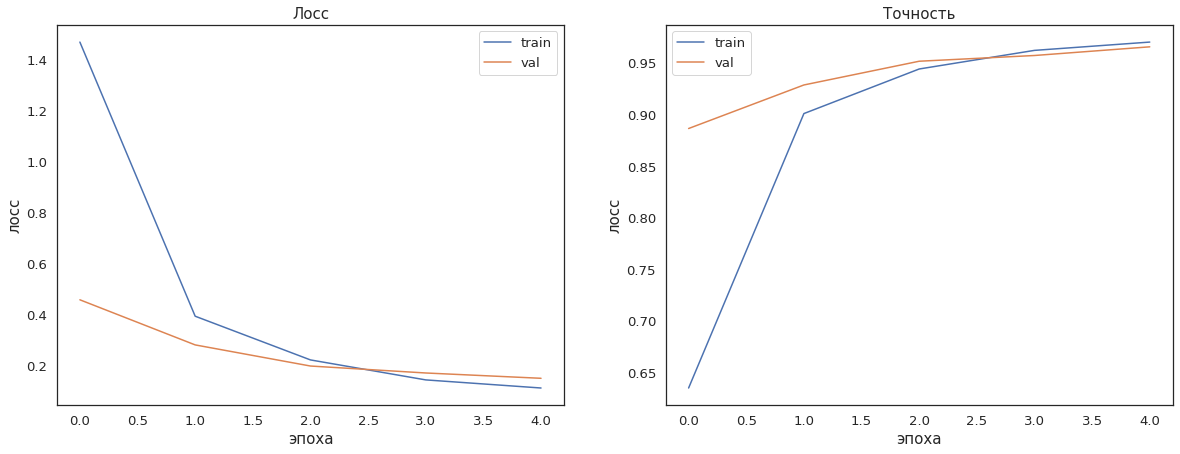

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

fine_tuning_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=5
)

> Сравните результаты и сделайте вывод.

#### Feature Extractor сети ResNet50

Заменяем последний слой классификатора на линейный классификатор, заморозим все остальные слои:

In [ ]:
clf_model = resnet50(pretrained=True)

# "замораживаем" все веса всех слоев
for param in clf_model.parameters():
    param.requires_grad = False

# этоn слой будет обучаемым
clf_model.fc = nn.Linear(2048, 47)
clf_model = clf_model.to(device)

Epoch 10 of 50 took 253.390s
  training loss (in-iteration): 	1.538995
  validation loss (in-iteration): 	1.317338
  training accuracy: 			58.92 %
  validation accuracy: 			65.10 %


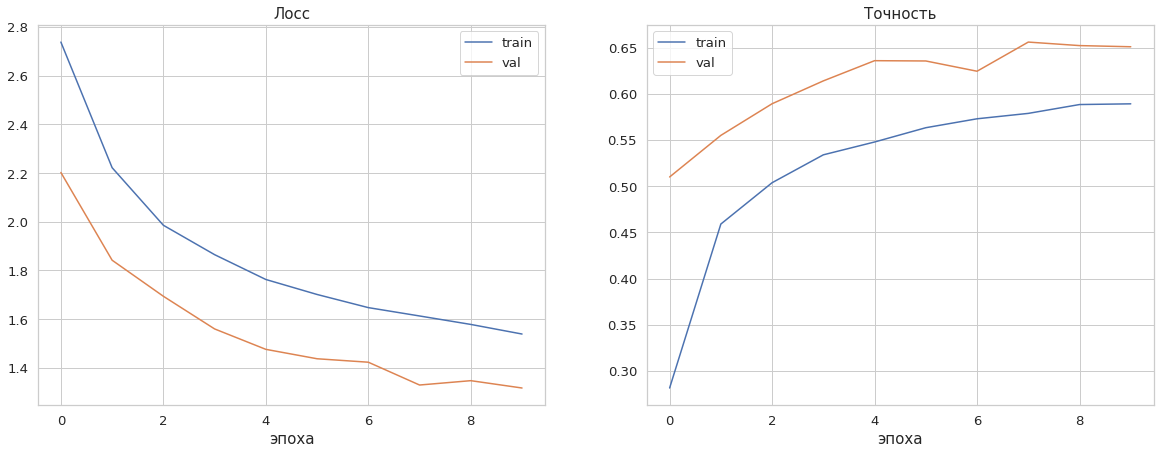

KeyboardInterrupt: ignored

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf_model.parameters(), lr=0.01)

clf_model, history = train(
    clf_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

> Сравните результаты Fine Tuning и Feature Extractor способов и сделайте выводы.

### Задание *

Попробуйте дообучить другие архитектуры:
- `DenseNet`
- `MnasNet`
- `InceptionV3`

In [ ]:
<Ваш код здесь>

### Нейросетевые дескрипторы

Для того, чтобы получить признаковое представление для обучения модели, нужно заменить последний слой классификатора на слой, который ничего не делает. 

То есть оставить тензор признаков как выход нейросети:

In [ ]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
extractor_model = resnet50(pretrained=True)
extractor_model.fc = Identity()

extractor_model.train(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Снова инициализируем даталоадеры:

In [ ]:
batch_size = 1

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Берем нейросетевые признаки с последнего слоя, сохраняя их в переменную `X`:

In [ ]:
X = []
Y = []

# то же самое, что и `extractor_model.eval()`
extractor_model.train(False)

# извлекаем признаки из обучающей выборки
for i, (image_batch, label_batch) in tqdm(enumerate(train_batch_gen), 
                                          total=len(train_dataset)/batch_size):
    features = extractor_model(image_batch).detach()
    X.append(features)
    Y.append(label_batch)
    if i == 100:
        break

# извлекаем признаки из валидационной выборки
for i, (image_batch, label_batch) in tqdm(enumerate(val_batch_gen), 
                                          total=len(val_dataset)/batch_size):
    features = extractor_model(image_batch).detach()
    X.append(features)
    Y.append(label_batch)
    if i == 10:
        break

In [ ]:
Y = np.array(Y)
X = np.concatenate(X)

print(X.shape, Y.shape)

(112, 2048) (112,)


Мы получили признаковое описание объектов и теперь можем работать с ними как с обычным датасетом.

---